In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils, layers, models, applications

In [35]:
# Entry Flow

def entry_flow(x) : 
  y = layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2))(x)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.Conv2D(filters = 64, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)

  r = layers.Conv2D(128, kernel_size = (1,1), strides = (2,2))(y)

  y = layers.SeparableConv2D(filters = 128, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 128, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 128, kernel_size = (3,3), strides = (2,2))(y)

  # residual과 resolution이 약간 달라서 reshape
  y = layers.Resizing(r.shape[1], r.shape[2])(y)
  z1 = tf.keras.layers.Add()([y,r])
  z1 = layers.BatchNormalization()(z1)
  z1 = layers.Activation('relu')(z1)


  r = layers.Conv2D(256, kernel_size = (1,1), strides = (2,2))(z1)

  y = layers.SeparableConv2D(filters = 256, kernel_size = (3,3))(z1)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 256, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 256, kernel_size = (3,3), strides = (2,2))(y)
  y = layers.Resizing(r.shape[1], r.shape[2])(y)

  z = tf.keras.layers.Add()([y,r])
  z = layers.BatchNormalization()(z)
  z = layers.Activation('relu')(z)

  r = layers.Conv2D(728, kernel_size = (1,1), strides = (2,2))(z)

  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(z)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3), strides = (2,2))(y)
  y = layers.Resizing(r.shape[1], r.shape[2])(y)

  z = tf.keras.layers.Add()([y,r])
  z = layers.BatchNormalization()(z)
  z = layers.Activation('relu')(z)

  return z,z1


In [4]:
# Middle flow

def middle_flow(x) :
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(x)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(y) 
  y = layers.Resizing(x.shape[1], x.shape[2])(y)

  z = tf.keras.layers.Add()([y,x])
  z = layers.BatchNormalization()(z)
  z = layers.Activation('relu')(z)
  return z

In [5]:
# Exit flow

def exit_flow(x) :
  y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(x)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 1024, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 1024, kernel_size = (3,3), strides = (2,2))(y)
  x = layers.SeparableConv2D(filters = 1024, kernel_size = (1,1), strides = (1,1))(x)
  y = layers.Resizing(x.shape[1], x.shape[2])(y)


  z = tf.keras.layers.Add()([y,x])
  z = layers.BatchNormalization()(z)
  z = layers.Activation('relu')(z)

  y = layers.SeparableConv2D(filters = 1536, kernel_size = (3,3))(z)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 1536, kernel_size = (3,3))(y)
  y = layers.BatchNormalization()(y)
  y = layers.Activation('relu')(y)
  y = layers.SeparableConv2D(filters = 2048, kernel_size = (3,3))(y)
  return y  

In [6]:
def decoder(low_img, aspp_img) :
  from tensorflow._api.v2.image import ResizeMethod
  low_level_img = layers.Conv2D(2048, kernel_size = (1,1))(low_img)   # ASPP 통과한 이미지와 채널 수 맞춤

  size = (low_img.shape[1],low_img.shape[2]) # resize img
  ASPP_img = tf.image.resize(aspp_img, size = size, method = ResizeMethod.BILINEAR)    # low level 이미지와 ASPP 통과한 이미지 resolution 맞춤

  concat_img = tf.keras.layers.Add()([low_level_img, ASPP_img])

  concat_img = layers.Conv2D(2, kernel_size = (3,3))(concat_img)
  img = tf.image.resize(concat_img, size = (500,500), method = ResizeMethod.BILINEAR)

  return img

In [36]:
# optimizer
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# loss
def weighted_loss(y_true, y_pred):
# Calculate the base loss
  from tensorflow.keras.losses import binary_crossentropy
  bc = binary_crossentropy(y_true, y_pred)
  # Apply the weights
  one_weight = 1.0
  zero_weight = 1e-2
  weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
  weight_vector = K.squeeze(weight_vector, axis=-1)
  weighted_ce = weight_vector * bc
  # Return the mean error
  return K.mean(weighted_ce)

In [40]:
def deeplabv3(input_shape) :
  x = layers.Input(input_shape)
  z, low_level_feature = entry_flow(x)
  z = middle_flow(z)
  ASPP_feature = exit_flow(z)
  output =  decoder(low_level_feature, ASPP_feature)
  model = models.Model(x, output)
  model.compile(loss=weighted_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy', dice_coef])
  return model

input_shape = (500,500,1)
deeplabv3(input_shape)

In [23]:
from tensorflow._api.v2.image import ResizeMethod


# entry_flow
input_shape = (500,500,1)
x = layers.Input(input_shape)
y = layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2))(x)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)
y = layers.Conv2D(filters = 64, kernel_size = (3,3))(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)

r = layers.Conv2D(128, kernel_size = (1,1), strides = (2,2))(y)

y = layers.SeparableConv2D(filters = 128, kernel_size = (3,3))(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)
y = layers.SeparableConv2D(filters = 128, kernel_size = (3,3))(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)
y = layers.SeparableConv2D(filters = 128, kernel_size = (3,3), strides = (2,2))(y)

# residual과 resolution이 약간 달라서 reshape
y = layers.Resizing(r.shape[1], r.shape[2])(y)
z1 = tf.concat([y,r],axis = -1 )
z1 = layers.BatchNormalization()(z1)
z1 = layers.Activation('relu')(z1)


r = layers.Conv2D(256, kernel_size = (1,1), strides = (2,2))(z1)

y = layers.SeparableConv2D(filters = 256, kernel_size = (3,3))(z1)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)
y = layers.SeparableConv2D(filters = 256, kernel_size = (3,3))(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)
y = layers.SeparableConv2D(filters = 256, kernel_size = (3,3), strides = (2,2))(y)
y = layers.Resizing(r.shape[1], r.shape[2])(y)

z = tf.concat([y,r], axis = -1)
z = layers.BatchNormalization()(z)
z = layers.Activation('relu')(z)

r = layers.Conv2D(728, kernel_size = (1,1), strides = (2,2))(z)

y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(z)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)
y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)
y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3), strides = (2,2))(y)
y = layers.Resizing(r.shape[1], r.shape[2])(y)

z = tf.concat([y,r], axis = -1)
z = layers.BatchNormalization()(z)
z = layers.Activation('relu')(z)


# middle_flow

y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(z)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)
y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)
y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(y) 
y = layers.Resizing(z.shape[1], z.shape[2])(y)

z = tf.concat([y,z], axis = -1)
z = layers.BatchNormalization()(z)
z = layers.Activation('relu')(z)


# exit_flow
y = layers.SeparableConv2D(filters = 728, kernel_size = (3,3))(z)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)
y = layers.SeparableConv2D(filters = 1024, kernel_size = (3,3))(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)
y = layers.SeparableConv2D(filters = 1024, kernel_size = (3,3), strides = (2,2))(y)

z = layers.SeparableConv2D(filters = 1024, kernel_size = (1,1), strides = (1,1))(z)
y = layers.Resizing(z.shape[1], z.shape[2])(y)

z = tf.concat([y,z], axis = -1)
z = layers.BatchNormalization()(z)
z = layers.Activation('relu')(z)

y = layers.SeparableConv2D(filters = 1536, kernel_size = (3,3))(z)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)
y = layers.SeparableConv2D(filters = 1536, kernel_size = (3,3))(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('relu')(y)
y = layers.SeparableConv2D(filters = 2048, kernel_size = (3,3))(y)

low_level_img = layers.Conv2D(2048, kernel_size = (1,1))(z1)   # ASPP 통과한 이미지와 채널 수 맞춤

size = (z1.shape[1],z1.shape[2]) # resize img
ASPP_img = tf.image.resize(y, size = size, method = ResizeMethod.BILINEAR)    # low level 이미지와 ASPP 통과한 이미지 resolution 맞춤
print('low_level_img : ',low_level_img.shape, 'ASPP_img : ', ASPP_img.shape)

concat_img = tf.concat([low_level_img, ASPP_img], axis = -1)
print('before 3X3 conv : ', concat_img.shape)
concat_img = layers.Conv2D(2, kernel_size = (3,3))(concat_img)
print('after 3X3 conv : ', concat_img.shape)
y = tf.image.resize(concat_img, size = (500,500), method = ResizeMethod.BILINEAR)


model = models.Model(x,y)
model.summary()

low_level_img :  (None, 124, 124, 2048) ASPP_img :  (None, 124, 124, 2048)
before 3X3 conv :  (None, 124, 124, 4096)
after 3X3 conv :  (None, 122, 122, 2)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 500, 500, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 249, 249, 32  320         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_137 (Batch  (No

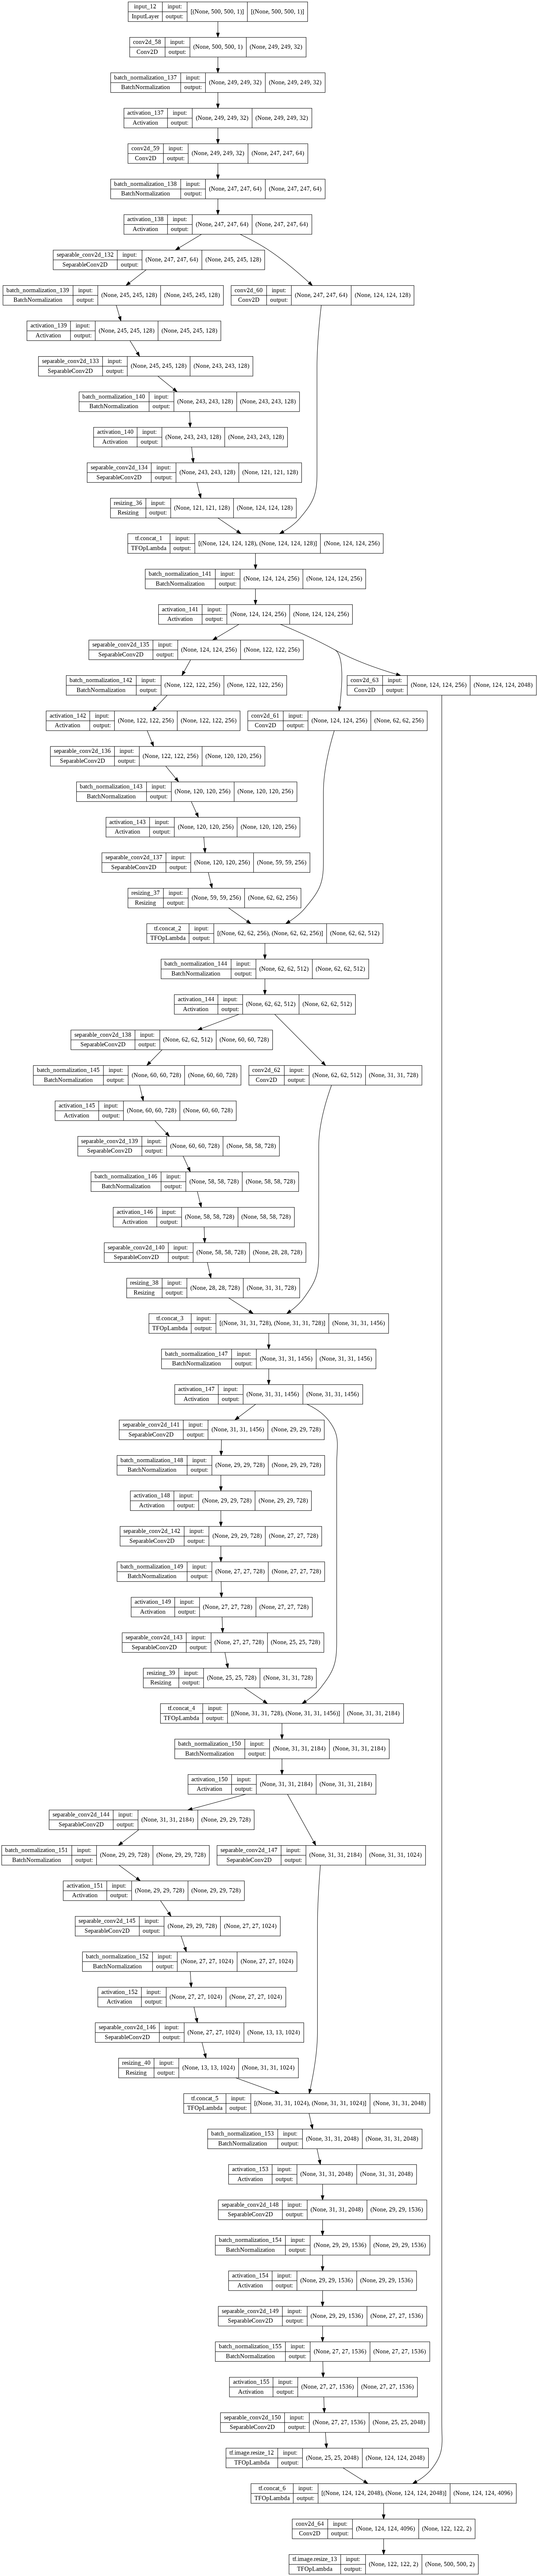

In [26]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [10]:
from tensorflow.keras import optimizers
model.compile(loss=weighted_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy', dice_coef])

NameError: ignored